# An Intuitive Tutorial to Gaussian Processes Regression

[Jie Wang](mailto:jie.wang@queensu.ca), [Offroad Robotics](https://offroad.engineering.queensu.ca/), Queen's University, Kingston, Canada


The whole notebook can be executed at

<a href="https://colab.research.google.com/github/jwangjie/Gaussian-Processes-Regression-Tutorial/blob/master/gpr_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The audience of this tutorial is the one who wants to use GP but not feels comfortable using it. This happens to me after finishing reading the first two chapters of the textbook **Gaussian Process for Machine Learning** [1]. There is a gap between the usage of GP and feel comfortable using it due to the difficulties in understanding the theory. When I was reading the textbook and watching tutorial videos online, I can follow the majority without too many difficulties. The content kind of makes sense to me. But even when I am trying to talk to myself what GP is, the big picture is blurry. After keep trying to understand GP from various recourses, including textbooks, blog posts, and open-sourced codes, I get my understandings sorted and summarize them up from my perspective. 

One thing I realized the difficulties in understanding GP is due to background varies, everyone has different knowledge. To understand GP, even to the intuitive level, needs to know multivariable Gaussian, kernel, conditional probability. If you familiar with these, start reading from [III. Math](#III.-Math). Entry or medium-level in deep learning (application level), without a solid understanding in machine learning theory, even cause more confusion in understanding GP. 

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/gpr_animation_wide.gif?raw=1" width="1000"/> 

[10]






## I.	Motivation

First of all, why use Gaussian Process to do regression? Or even, what is regression? Regression is a common machine learning task that can be described as Given some observed data points (training dataset), finding a function that represents the dataset as close as possible, then using the function to make predictions at new data points. Regression can be conducted with polynomials, and it's common there is more than one possible function that fits the observed data. Besides getting predictions by the function, we also want to know how certain these predictions are. Moreover, quantifying uncertainty is super valuable to achieve an efficient learning process. The areas with the least certainty should be explored more. 

In a word, GP can be used to make predictions at new data points and can tell us how certain these predictions are. 

<div id="image-table">
    <table>
	    <tr>
    	    <td style="padding:10px">
        	    <img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/regression1.png?raw=1" width="400"/> [2]
      	    </td>
            <td style="padding:10px">
            	<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/regression2.png?raw=1" width="550"/>
            </td>
        </tr>
    </table>
</div> 

## II. Basics 

### A.	Gaussian (Normal) Distribution  

Let's talk about Gaussian. 

A random variable $X$ is said to be normally distributed with mean $\mu$ and variance $\sigma^2$ if its probability density function (PDF) is 
$$ P_X(x) = \frac{1}{\sqrt{2 \pi} \sigma} exp{\left(-\frac{{\left(x - \mu \right)}^{2}}{2 \sigma^{2}}\right)}$$

Here, $X$ represents random variables and $x$ is the real argument. The Gaussian or Normal distribution of $X$ is usually represented by $ P(x) ~ \sim\mathcal{N}(\mu, \sigma^2)$. 

A $1-D$ Gaussian PDF is plotted below. We generate `n` number random sample points from a $1-D$ Gaussian distribution on `x` axis. 

In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.format'] = 'pdf'

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


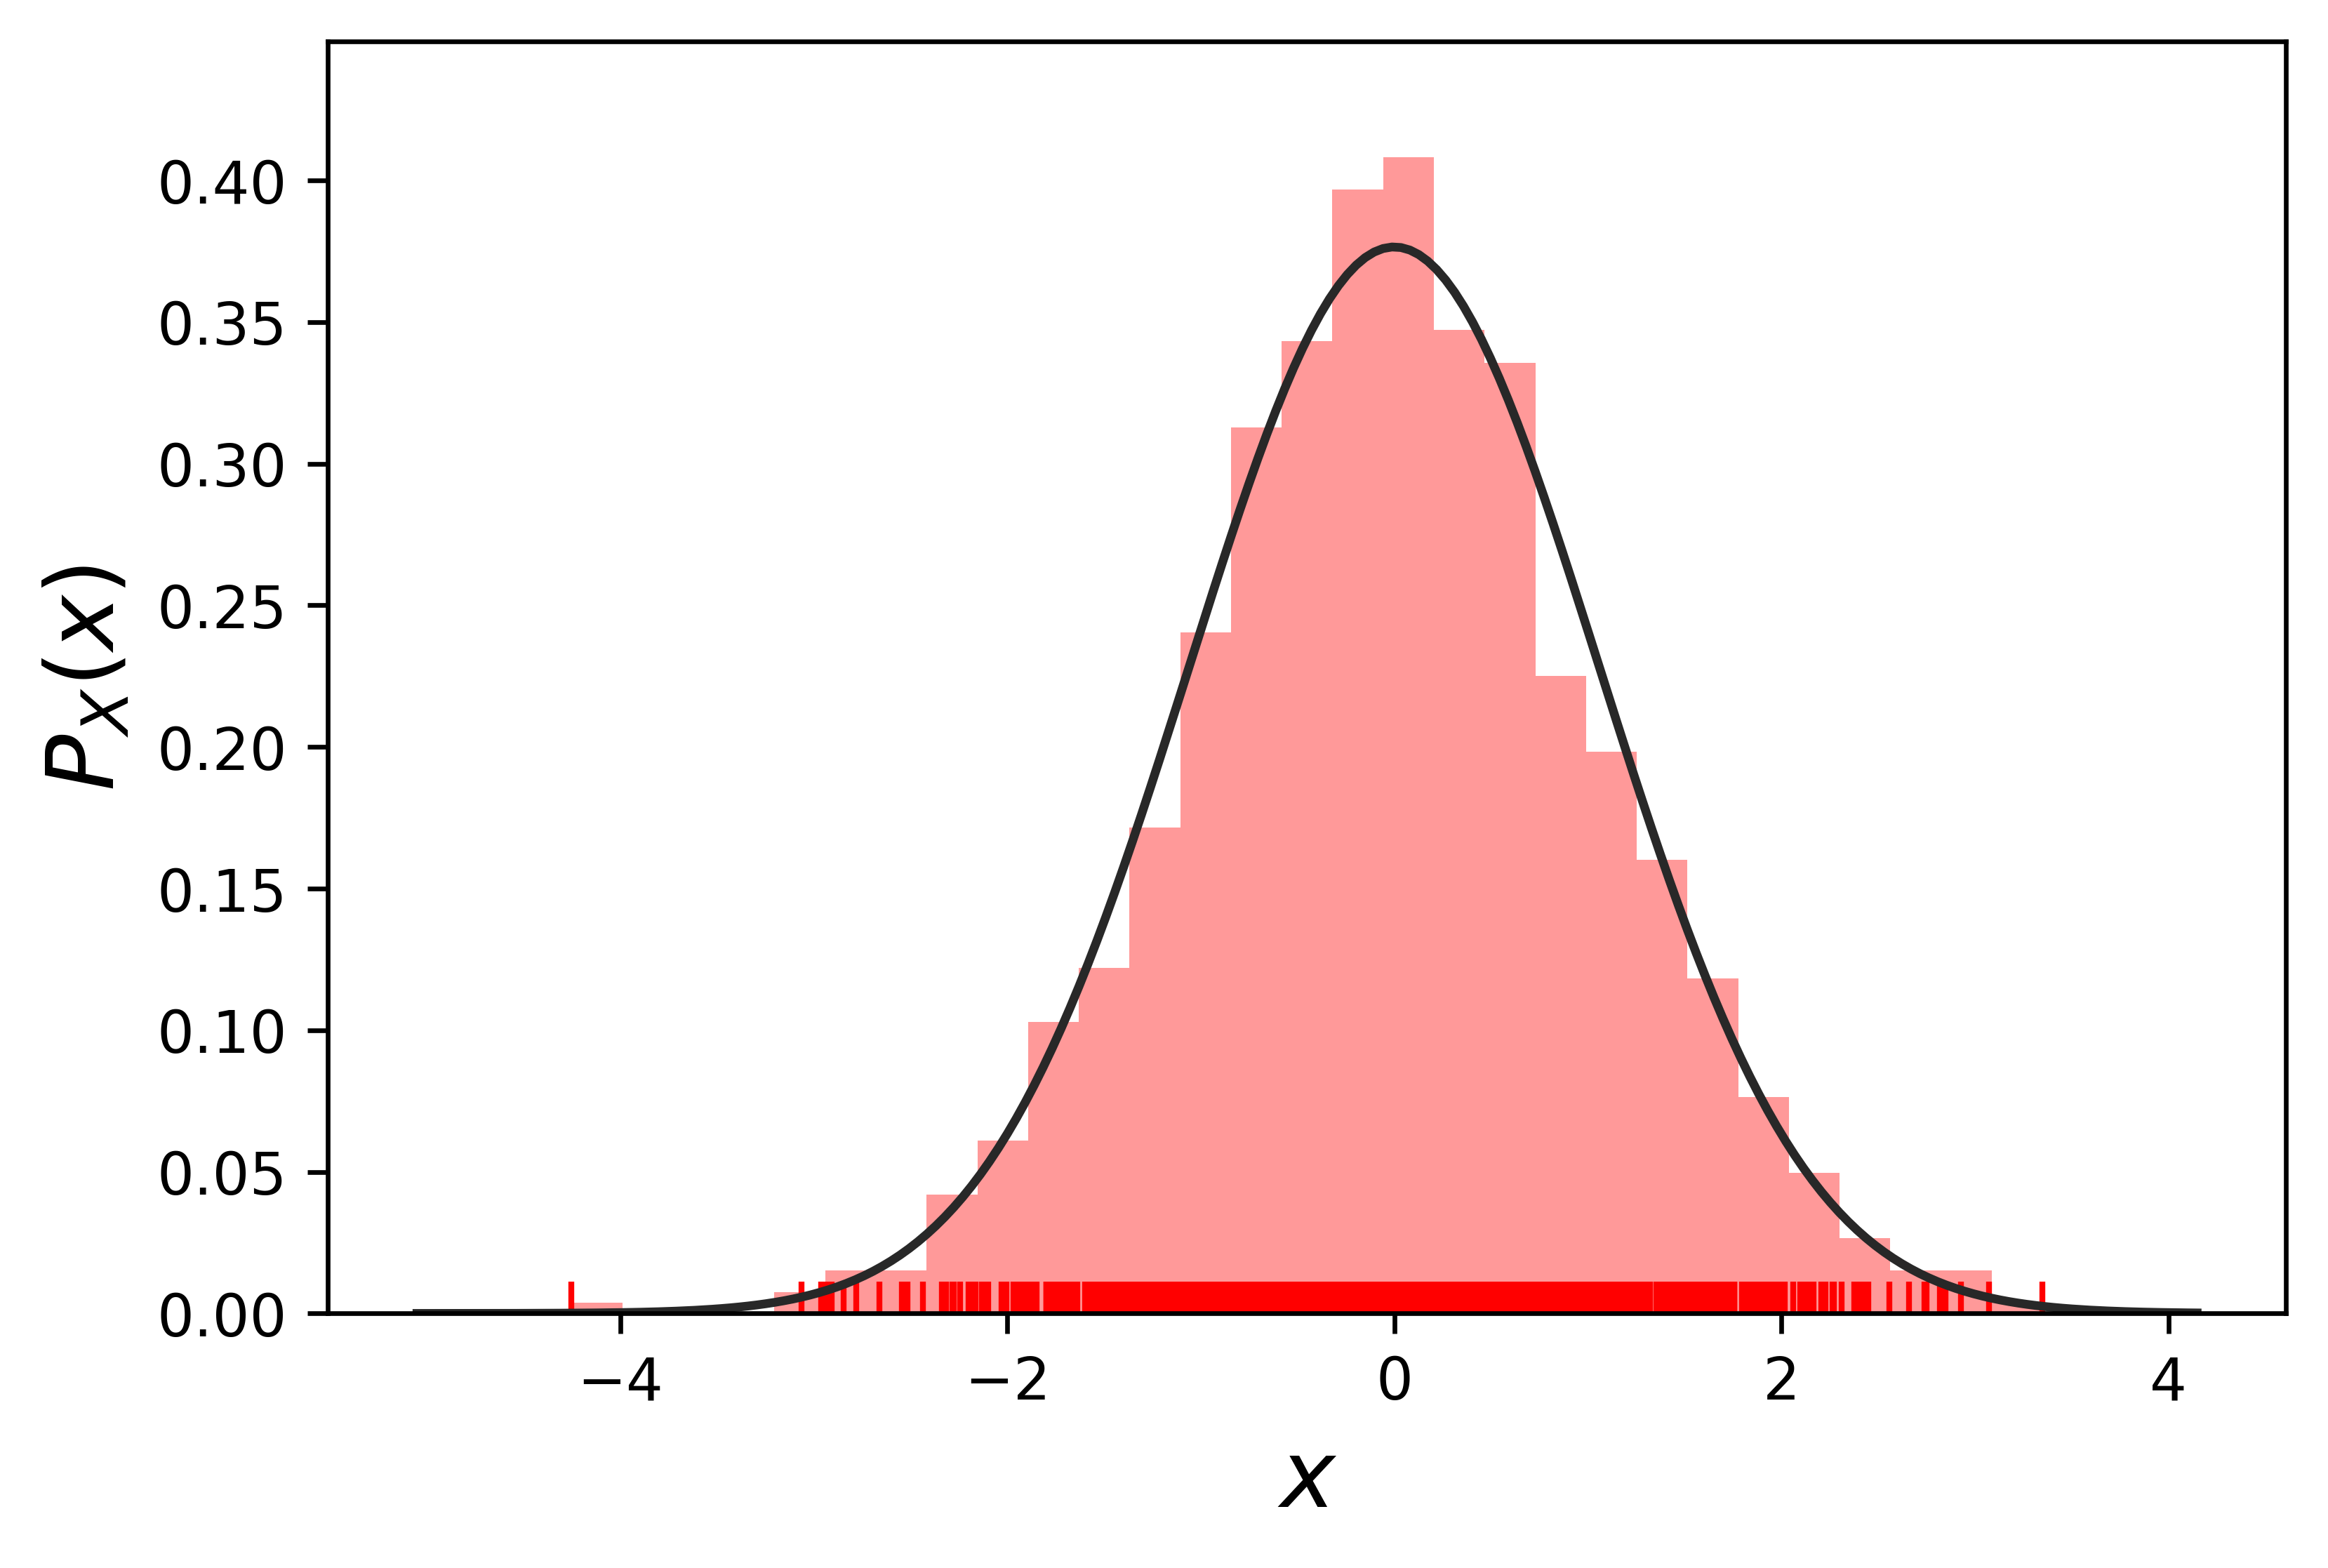

In [ ]:
from scipy.stats import norm

# Plot 1-D gaussian
n = 1         # n number of independent 1-D gaussian 
m= 1000       # m points in 1-D gaussian 
f_random = np.random.normal(size=(n, m)) 
# more information about 'size': https://www.sharpsightlabs.com/blog/numpy-random-normal/ 
#print(f_random.shape)

for i in range(n):
    #sns.distplot(f_random[i], hist=True, rug=True, vertical=True, color="orange")
    sns.distplot(f_random[i], hist=True, rug=True, fit=norm, kde=False, color="r", vertical=False)

#plt.title('1000 random samples by a 1-D Gaussian')

plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$P_X(x)$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
plt.savefig('1d_random')

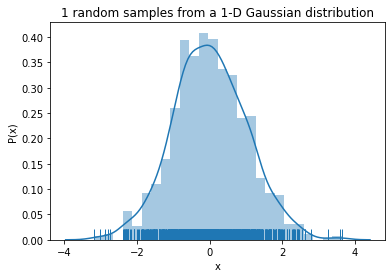

In [ ]:
# Plot 1-D gaussian
n = 1         # n number of independent 1-D gaussian 
m= 1000       # m points in 1-D gaussian 
f_random = np.random.normal(size=(n, m)) 
# more information about 'size': https://www.sharpsightlabs.com/blog/numpy-random-normal/ 
#print(f_random.shape)

for i in range(n):
    #sns.distplot(f_random[i], hist=True, rug=True, vertical=True, color="orange")
    sns.distplot(f_random[i], hist=True, rug=True)

plt.title('1 random samples from a 1-D Gaussian distribution')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

We generated data points that follow the normal distribution. On the other hand, we can model data points, assume these points are Gaussian, model as a function, and do regression using it. As shown above, a kernel density and histogram of the generated points were estimated. The kernel density estimation looks a normal distribution due to there are plenty `(m=1000)` observation points to get this Gaussian looking PDF. In regression, even we don't have that many observation data, we can model the data as a function that follows a normal distribution if we assume a Gaussian prior. 

The Gaussian PDF $\mathcal{N}(\mu, \sigma^2)$ is completely characterized by the two parameters $\mu$ and $\sigma$, they can be obtained from the PDF as [3]

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/1dGaussian.png?raw=1" width="550"/> 

We have a random generated dataset in $1-D$ $\mathbf{D}=[x^{(1)}, x^{(2)}, \ldots, x^{(m)}]$. We sampled the generated dataset and got a $1-D$Gaussian bell curve. 

Now, if we project all points $[x^{(1)}, x^{(2)}, \ldots, x^{(m)}]$ on the x-axis to another **space**. In this space, We treat all points $[x^{(1)}, x^{(2)}, \ldots, x^{(m)}]$ as a vector $X_1$, and plot $X_1$ on the new $X$ axis at $X = 0$. 

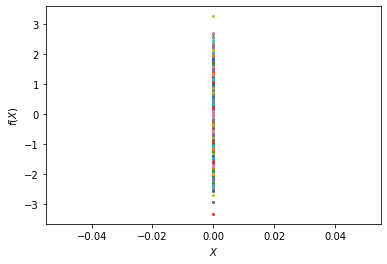

In [ ]:
n = 1         # n number of independent 1-D gaussian 
m= 1000       # m points in 1-D gaussian  
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, 'o', linewidth=1, markersize=1, markeredgewidth=2)
plt.xlabel('$X$')
plt.ylabel('$f(X)$')
plt.show()

It's clear that the vector $X_1$ is Gaussian. It looks like we did nothing but vertically plot the vector points $X_1$. 
Next, we can plot multiple independent Gaussian in the $X-Y$ coordinates. For example, put vector $X_1$ at at $X = 0$ and another vector $X_2$ at at $X = 1$. 

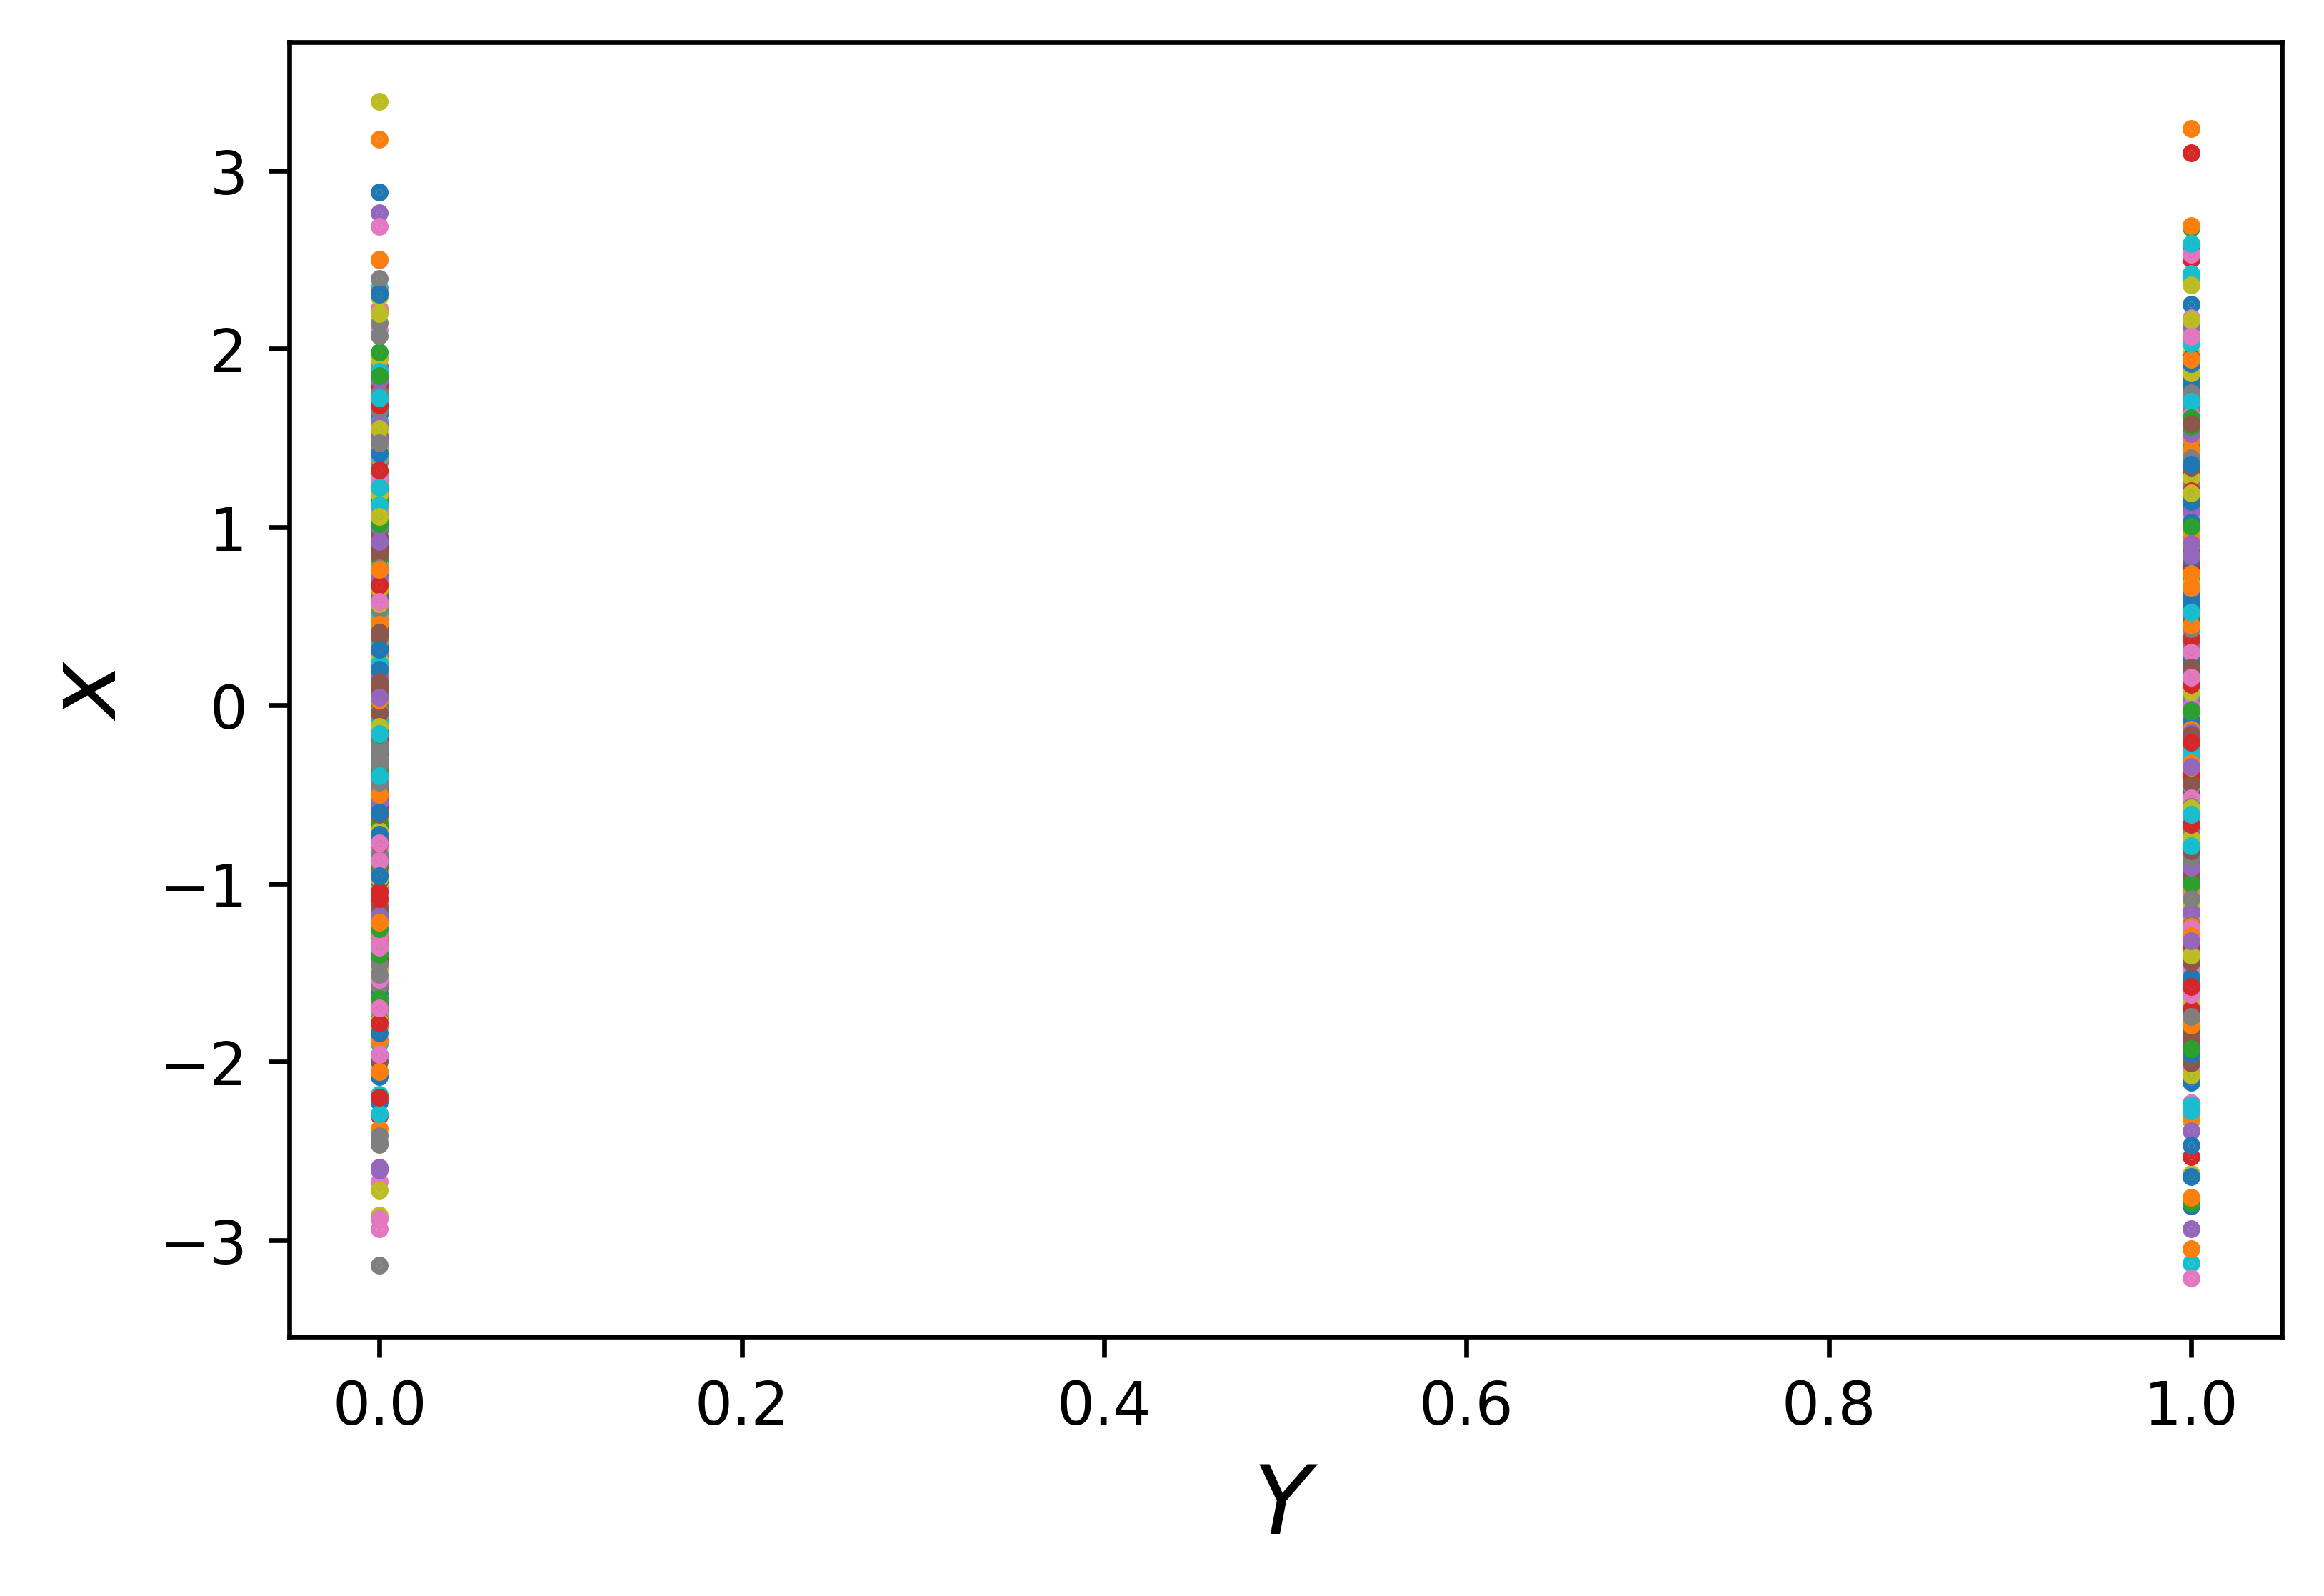

In [ ]:
n = 2          
m = 1000
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, 'o', linewidth=1, markersize=1, markeredgewidth=2)

plt.xlabel(r'$Y$', fontsize = 16)
plt.ylabel(r'$x$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
plt.savefig('2gaussian')


Keep in mind that both vecotr $X_1$ and $X_2$ are Gaussian. 

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2gaussian.png?raw=1" width="500"/> 

Let's do something interesting. Let's connect points of $X_1$ and $X_2$ by lines. For now, we only generate 10 random points for $X_1$ and $X_2$, and then join them up as 10 lines. Keep in mind, these random generated 10 points are Gaussian. 

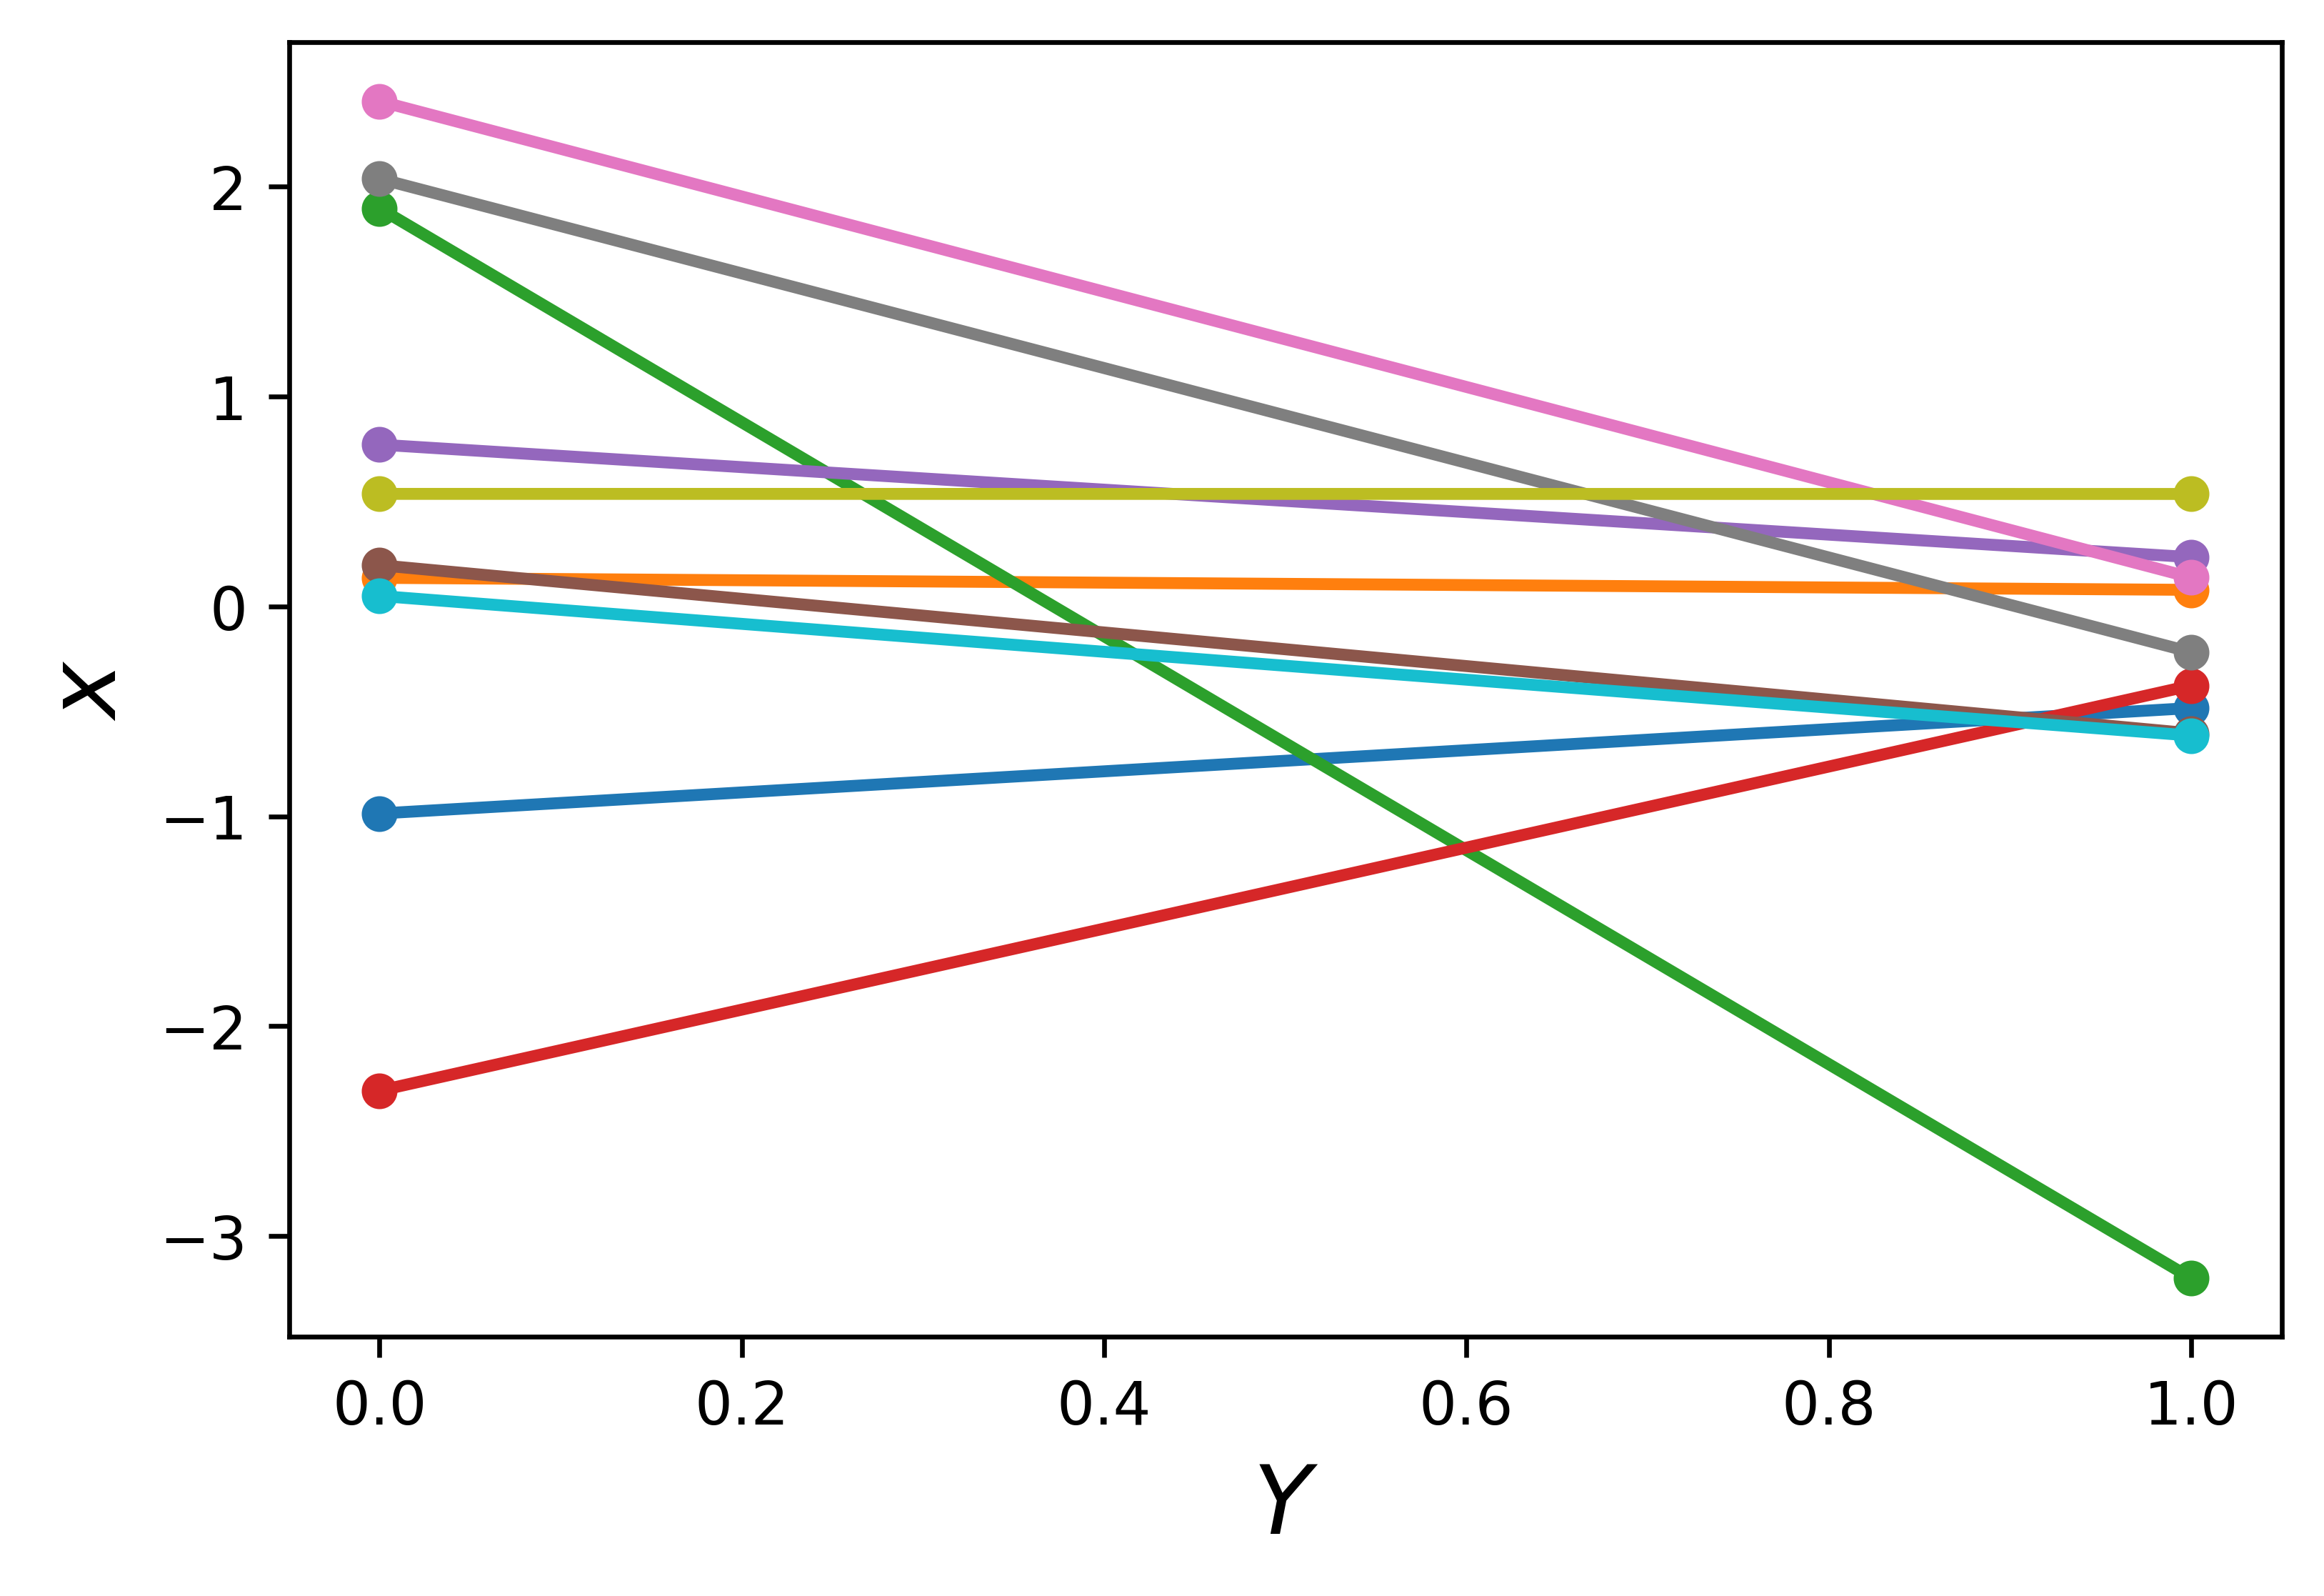

In [ ]:
n = 2          
m = 10
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, '-o', linewidth=2, markersize=4, markeredgewidth=2)
plt.xlabel(r'$Y$', fontsize = 16)
plt.ylabel(r'$x$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
plt.savefig('random_x1_x2')

Going back to think about regression. These lines look like **functions** for each pair of points. On the other hand, the plot also looks like we are sampling the region $[0, 1]$ with 10 linear functions even there are only two points on each line. In the sampling perspective, the $[0, 1]$ domain is our region of interest, i.e. the specific region we do our regression. This sampling looks even more clear if we generate more independent Gaussian and connecting points in order by lines. 

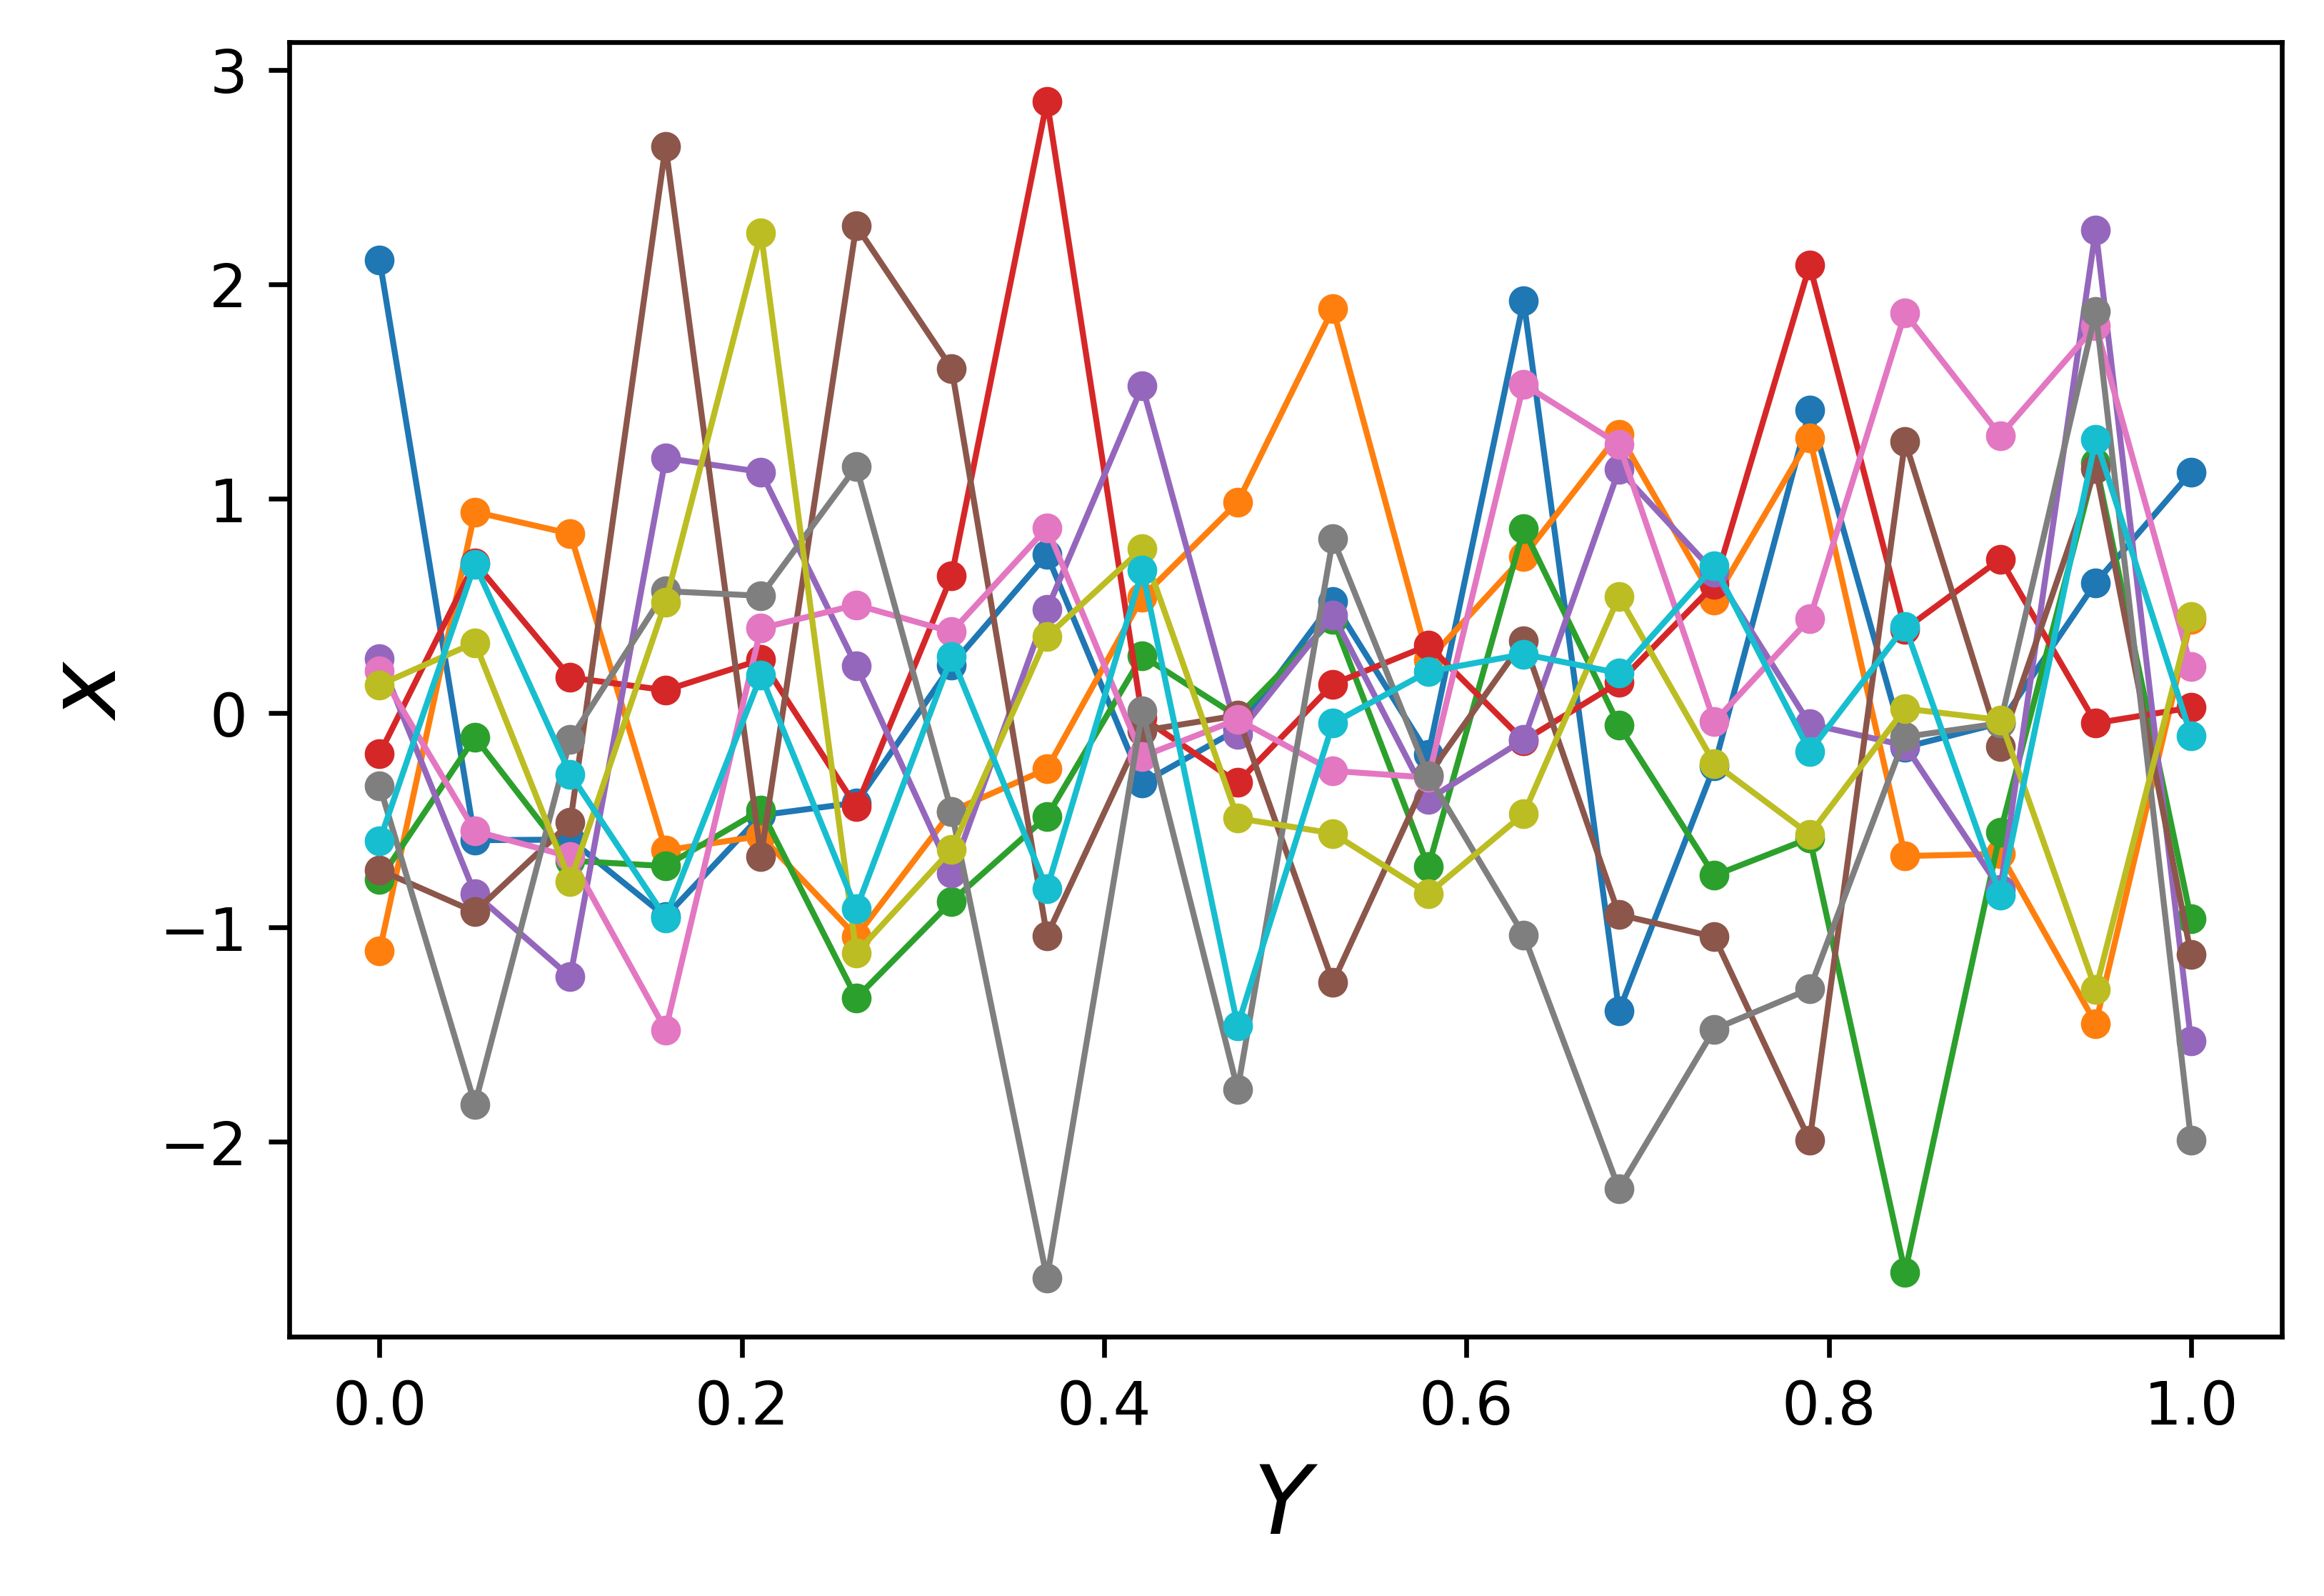

In [ ]:
n = 20          
m = 10
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, '-o', linewidth=1, markersize=3, markeredgewidth=2)

plt.xlabel(r'$Y$', fontsize = 16)
plt.ylabel(r'$x$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
plt.savefig('random_x1_x20')

Wait for a second, what we are trying to do by connecting random generated independent Gaussian points? Even these lines look like functions, but they are too noisy. If $X$ is our input space, these functions are meaningless for the regression task. We can do no prediction by using these functions. The functions should be smoother, meaning input points that are close to each other should have similar values of the function. 

Thus, functions by connecting independent Gaussian are not proper for regression, we need Gaussians that correlated to each other. How to describe joint Gaussian? Multivariable Gaussian.  

### B. Multivariate Normal Distribution (MVN)

In some situations, a system (set of data) has to be described by more than more feature variables $[x_1, x_2, \ldots, x_n]$, and these variables are correlated. If we want to model the data all in one go as Gaussian, we need multivariate Gaussian. Here are examples of the $2-D$ Gaussian. A data center is monitored by the CPU load $x_1$ and memory use $x_2$. [3]  

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2dGaussian.png?raw=1" width="550"/>

The $2-D$ gaussian can be visualized as a 3D bell curve with the heights representing probability density. The $P(x_1, x_2)$ is the [joint probability distribution](https://en.wikipedia.org/wiki/Joint_probability_distribution#Density_function_or_mass_function). 

<div id="image-table">
    <table>
	    <tr>
    	    <td style="padding:10px">
        	    <img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2d_gaussian3D_0.8.png?raw=1" width="400"/>
      	    </td>
            <td style="padding:10px">
            	<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2d_gaussian_0.8.png?raw=1" width="380"/>
            </td>
        </tr>
    </table>
</div> 

Goes to [Appendix A](#Appendix-A) if you want to generate image on the left. 

Formally, multivariate Gaussian is expressed as [4]

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/mul_var_gaussian.png?raw=1" width="400"/>

The `mean vector` $\mu$ is a 2d vector $(\mu_1, \mu_2)$, which are independent mean of each variable $x_1$ and $x_2$.

The covariance matrix of $2-D$ Gaussian is $\begin{pmatrix} \sigma^2_1 & \sigma_{12} \\ \sigma_{21} & \sigma^2_2 \end{pmatrix}$. The diagonal terms are independent variances of each variable, $x_1$ and $x_2$. The offdiagonal terms represents correlations between the two variables. A correlation component represents how much one variable is related to another variable. 

A $2-D$ Gaussian can be expressed as 
$$ \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \sim \mathcal{N}\left(\begin{pmatrix} \mu1 \\ \mu_2 \end{pmatrix}, \begin{pmatrix} \sigma^2_1 & \sigma_{12} \\ \sigma_{21} & \sigma^2_2 \end{pmatrix}\right) \sim \mathcal{N}(\mu, \Sigma)$$

When we have an $N-D$ Gaussian, the covariance matrix $\Sigma$ is $N×N$ and its $(i,j)$ element is $\Sigma_{ij}=cov(y_i,y_j)$. The $\Sigma$ is a symmetric matrix and stores the pairwise covariances of all the jointly modeled random variables.

Play around with the covariance matrix to see the correlations between the two Gaussians. 

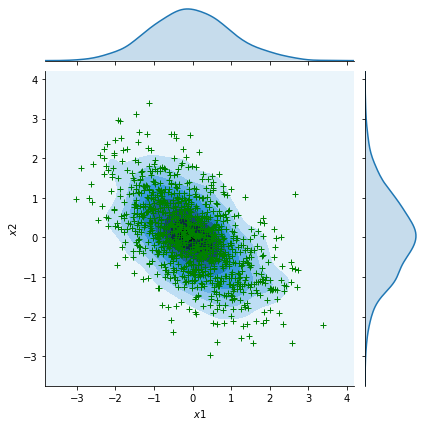

In [ ]:
import pandas as pd
import seaborn as sns

mean, cov = [0., 0.], [(1., -0.6), (-0.6, 1.)]
data = np.random.multivariate_normal(mean, cov, 1000)
df = pd.DataFrame(data, columns=["x1", "x2"])
g = sns.jointplot("x1", "x2", data=df, kind="kde")

#(sns.jointplot("x1", "x2", data=df).plot_joint(sns.kdeplot))

g.plot_joint(plt.scatter, c="g", s=30, linewidth=1, marker="+")

#g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$x1$", "$x2$");

#g.ax_joint.legend_.remove()
plt.show()

Another good MVN visualization is [Multivariante Gaussians and Mixtures of Gaussians (MoG)](https://www.cs.toronto.edu/~guerzhoy/411/lec/W08/MoG.html).

Besides the joint probalility, we are more interested to the conditional probability. If we cut a slice on the 3D bell curve or draw a line on the elipse contour, we got the conditional probability distribution $P(x_1 \vert \, x_2)$. The conditional distribution is also Gaussian. 

<div id="image-table">
    <table>
	    <tr>
    	    <td style="padding:10px">
        	    <img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2d_gaussian_conditional3D.png?raw=1" width="400"/>
      	    </td>
            <td style="padding:10px">
            	<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2d_gaussian_conditional.png?raw=1" width="300"/>
            </td>
        </tr>
    </table>
</div> 

### C. Kernals 

We want to smooth the sampling functions by defining the covariance functions. Considering the fact that when two vectors are similar, their dot product output value is high. It is very clear to see this in the dot product equation $A\,B = AB\,cos\theta$, where $\theta$ is the angle between two vectors. If an algorithm is defined solely in terms of inner products in input space then it can be lifted into feature space by replacing occurrences of those inner products by $k(x,\ x^\prime)$; we call $k(\bullet,\bullet)$ a kernel function [1]. 

A popular covariance function (aka kernel function) is squared exponential kernal, also called the radial basis function (RBF) kernel or Gaussian kernel, defined as 

$$ cov(x_i, x_j)=\exp\left(-~\frac{(x_i-x_j)^2}{2}\right)$$

Let's re-plot 20 independent Gaussian and connecting points in order by lines. Instead of generating 20 independent Gaussian before, we do the plot of a $20-D$ Gaussian with a identity convariance matrix. 

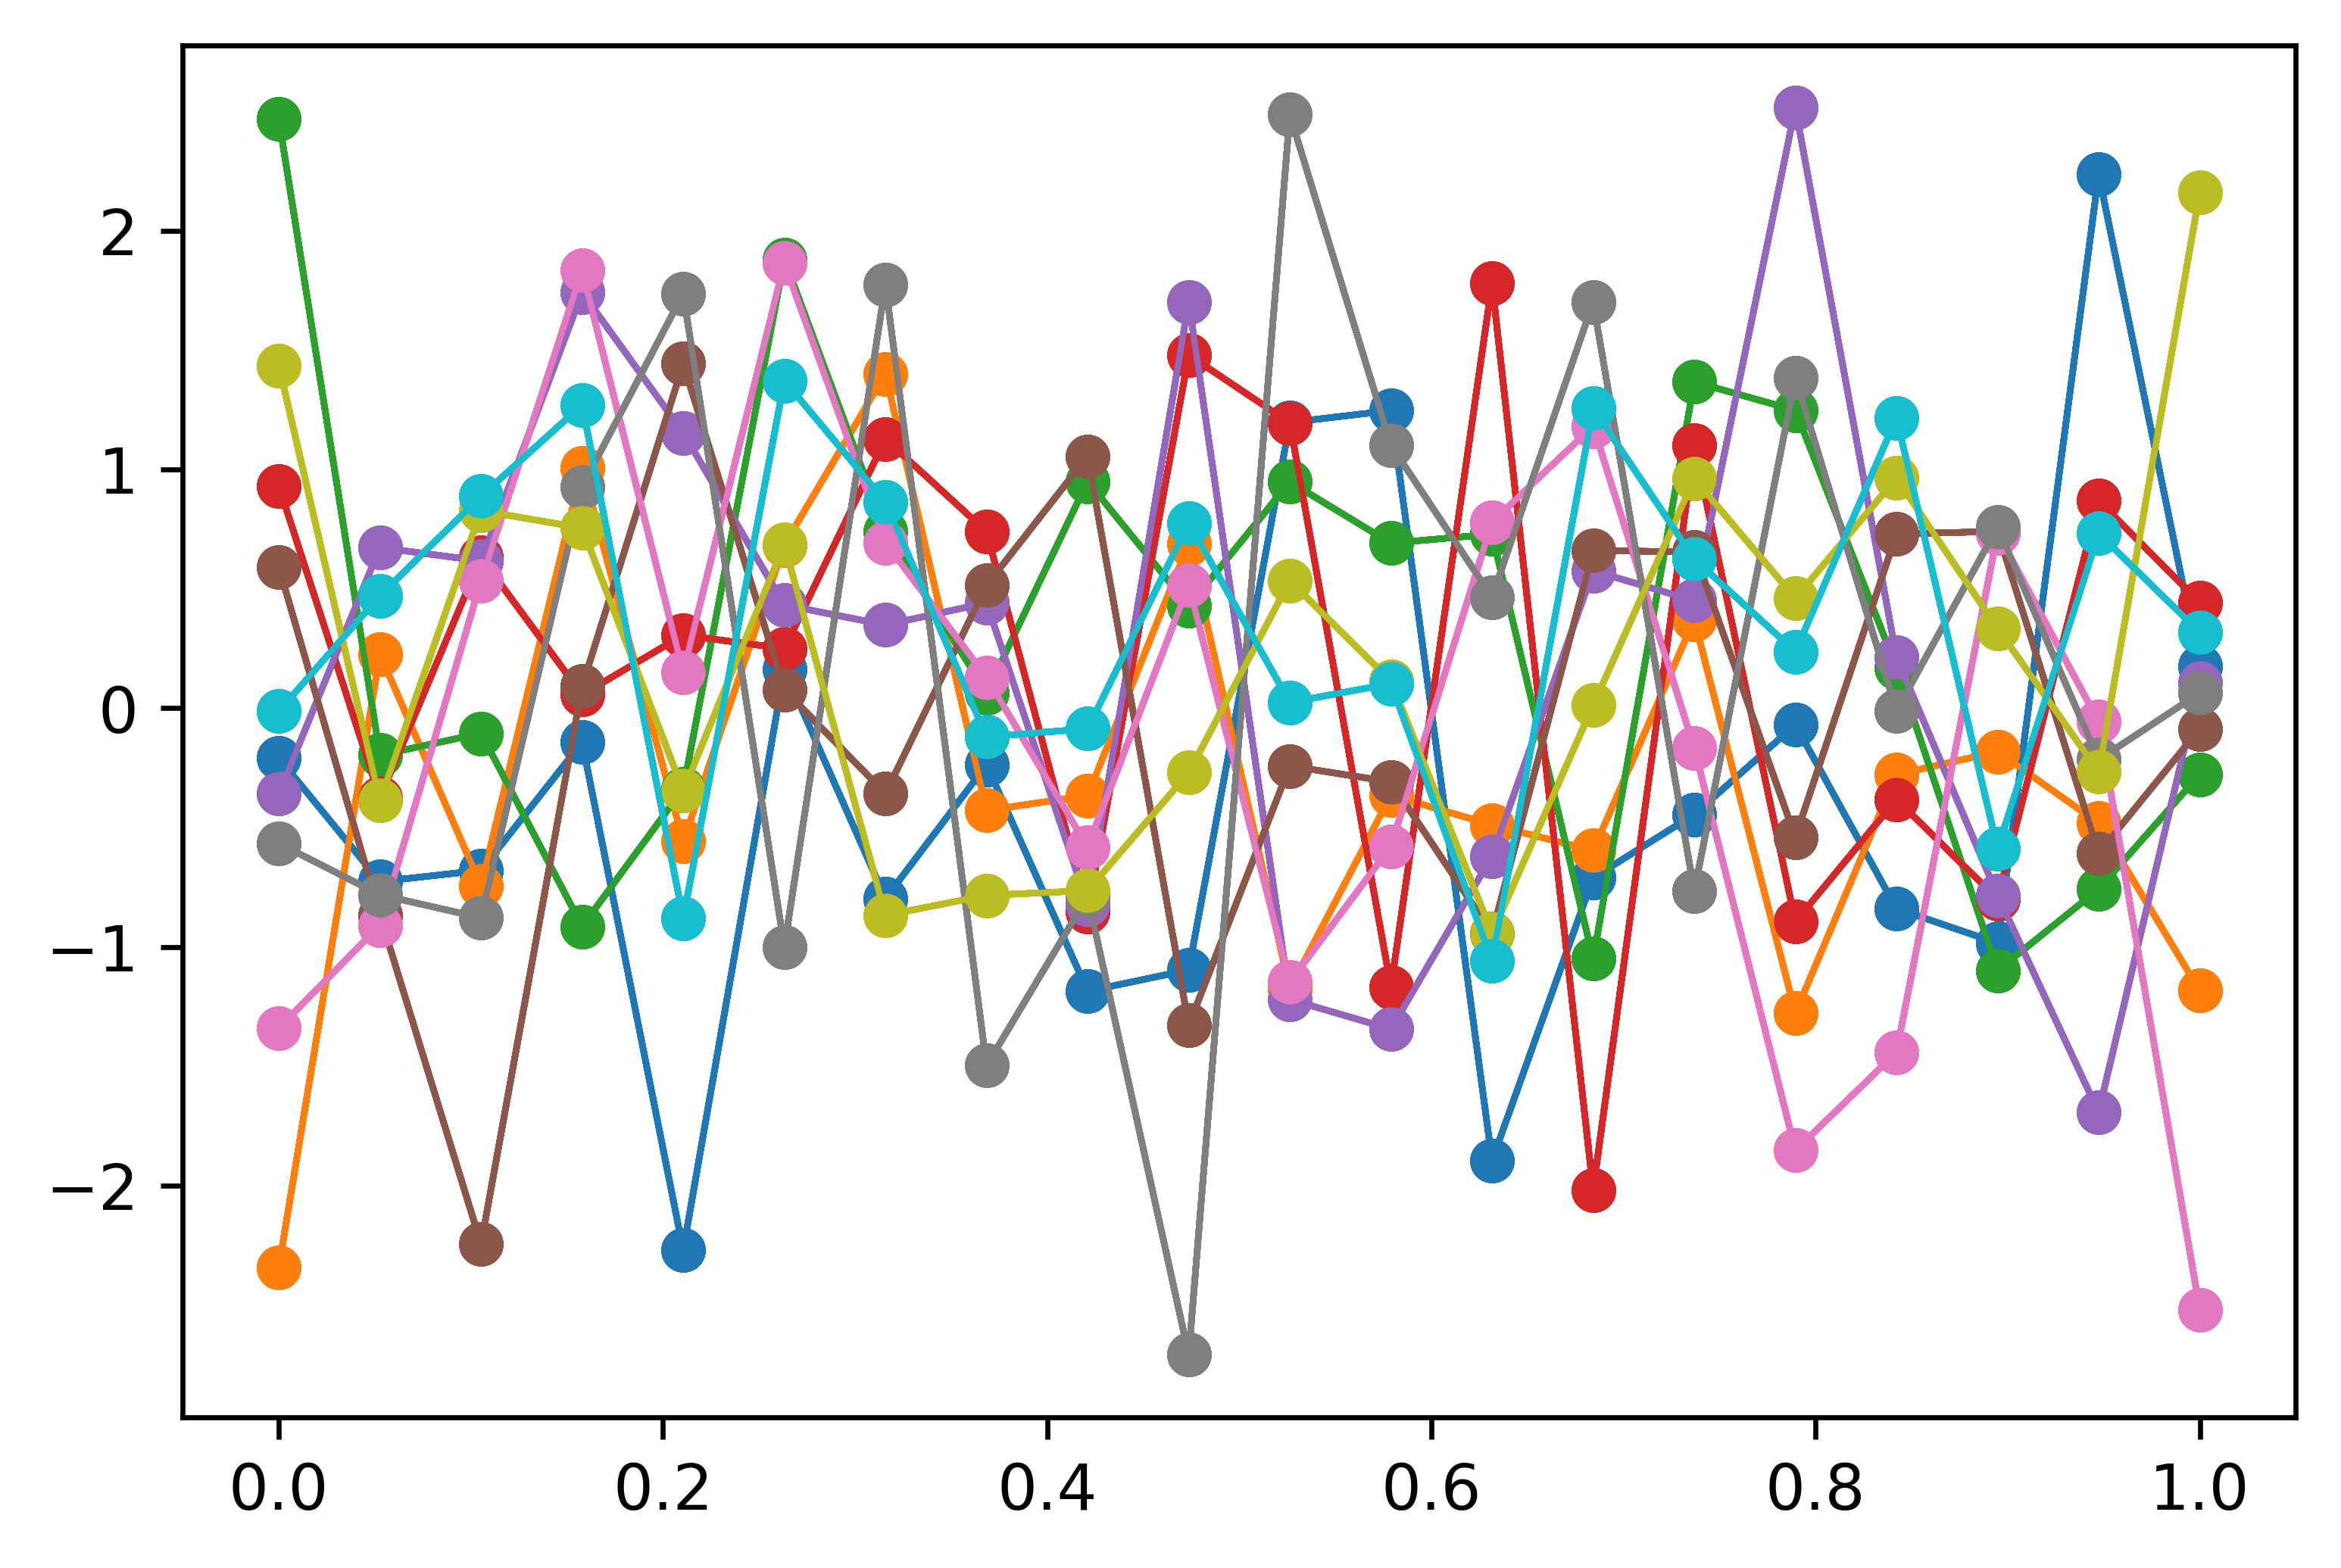

In [ ]:
n = 20 
m = 10

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, cov, m).T

plt.clf()

#plt.plot(Xshow, f_prior, '-o')
Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
# plt.title('10 samples of the 20-D gaussian prior')
# plt.show()
plt.savefig('20d_gaussian_prior')

We got exactly the same plot as expected. Now let's kernelizing our funcitons by use the RBF as our convariace. 

In [ ]:
# Define the kernel
def kernel(a, b):
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return np.exp(-.5 * sqdist)

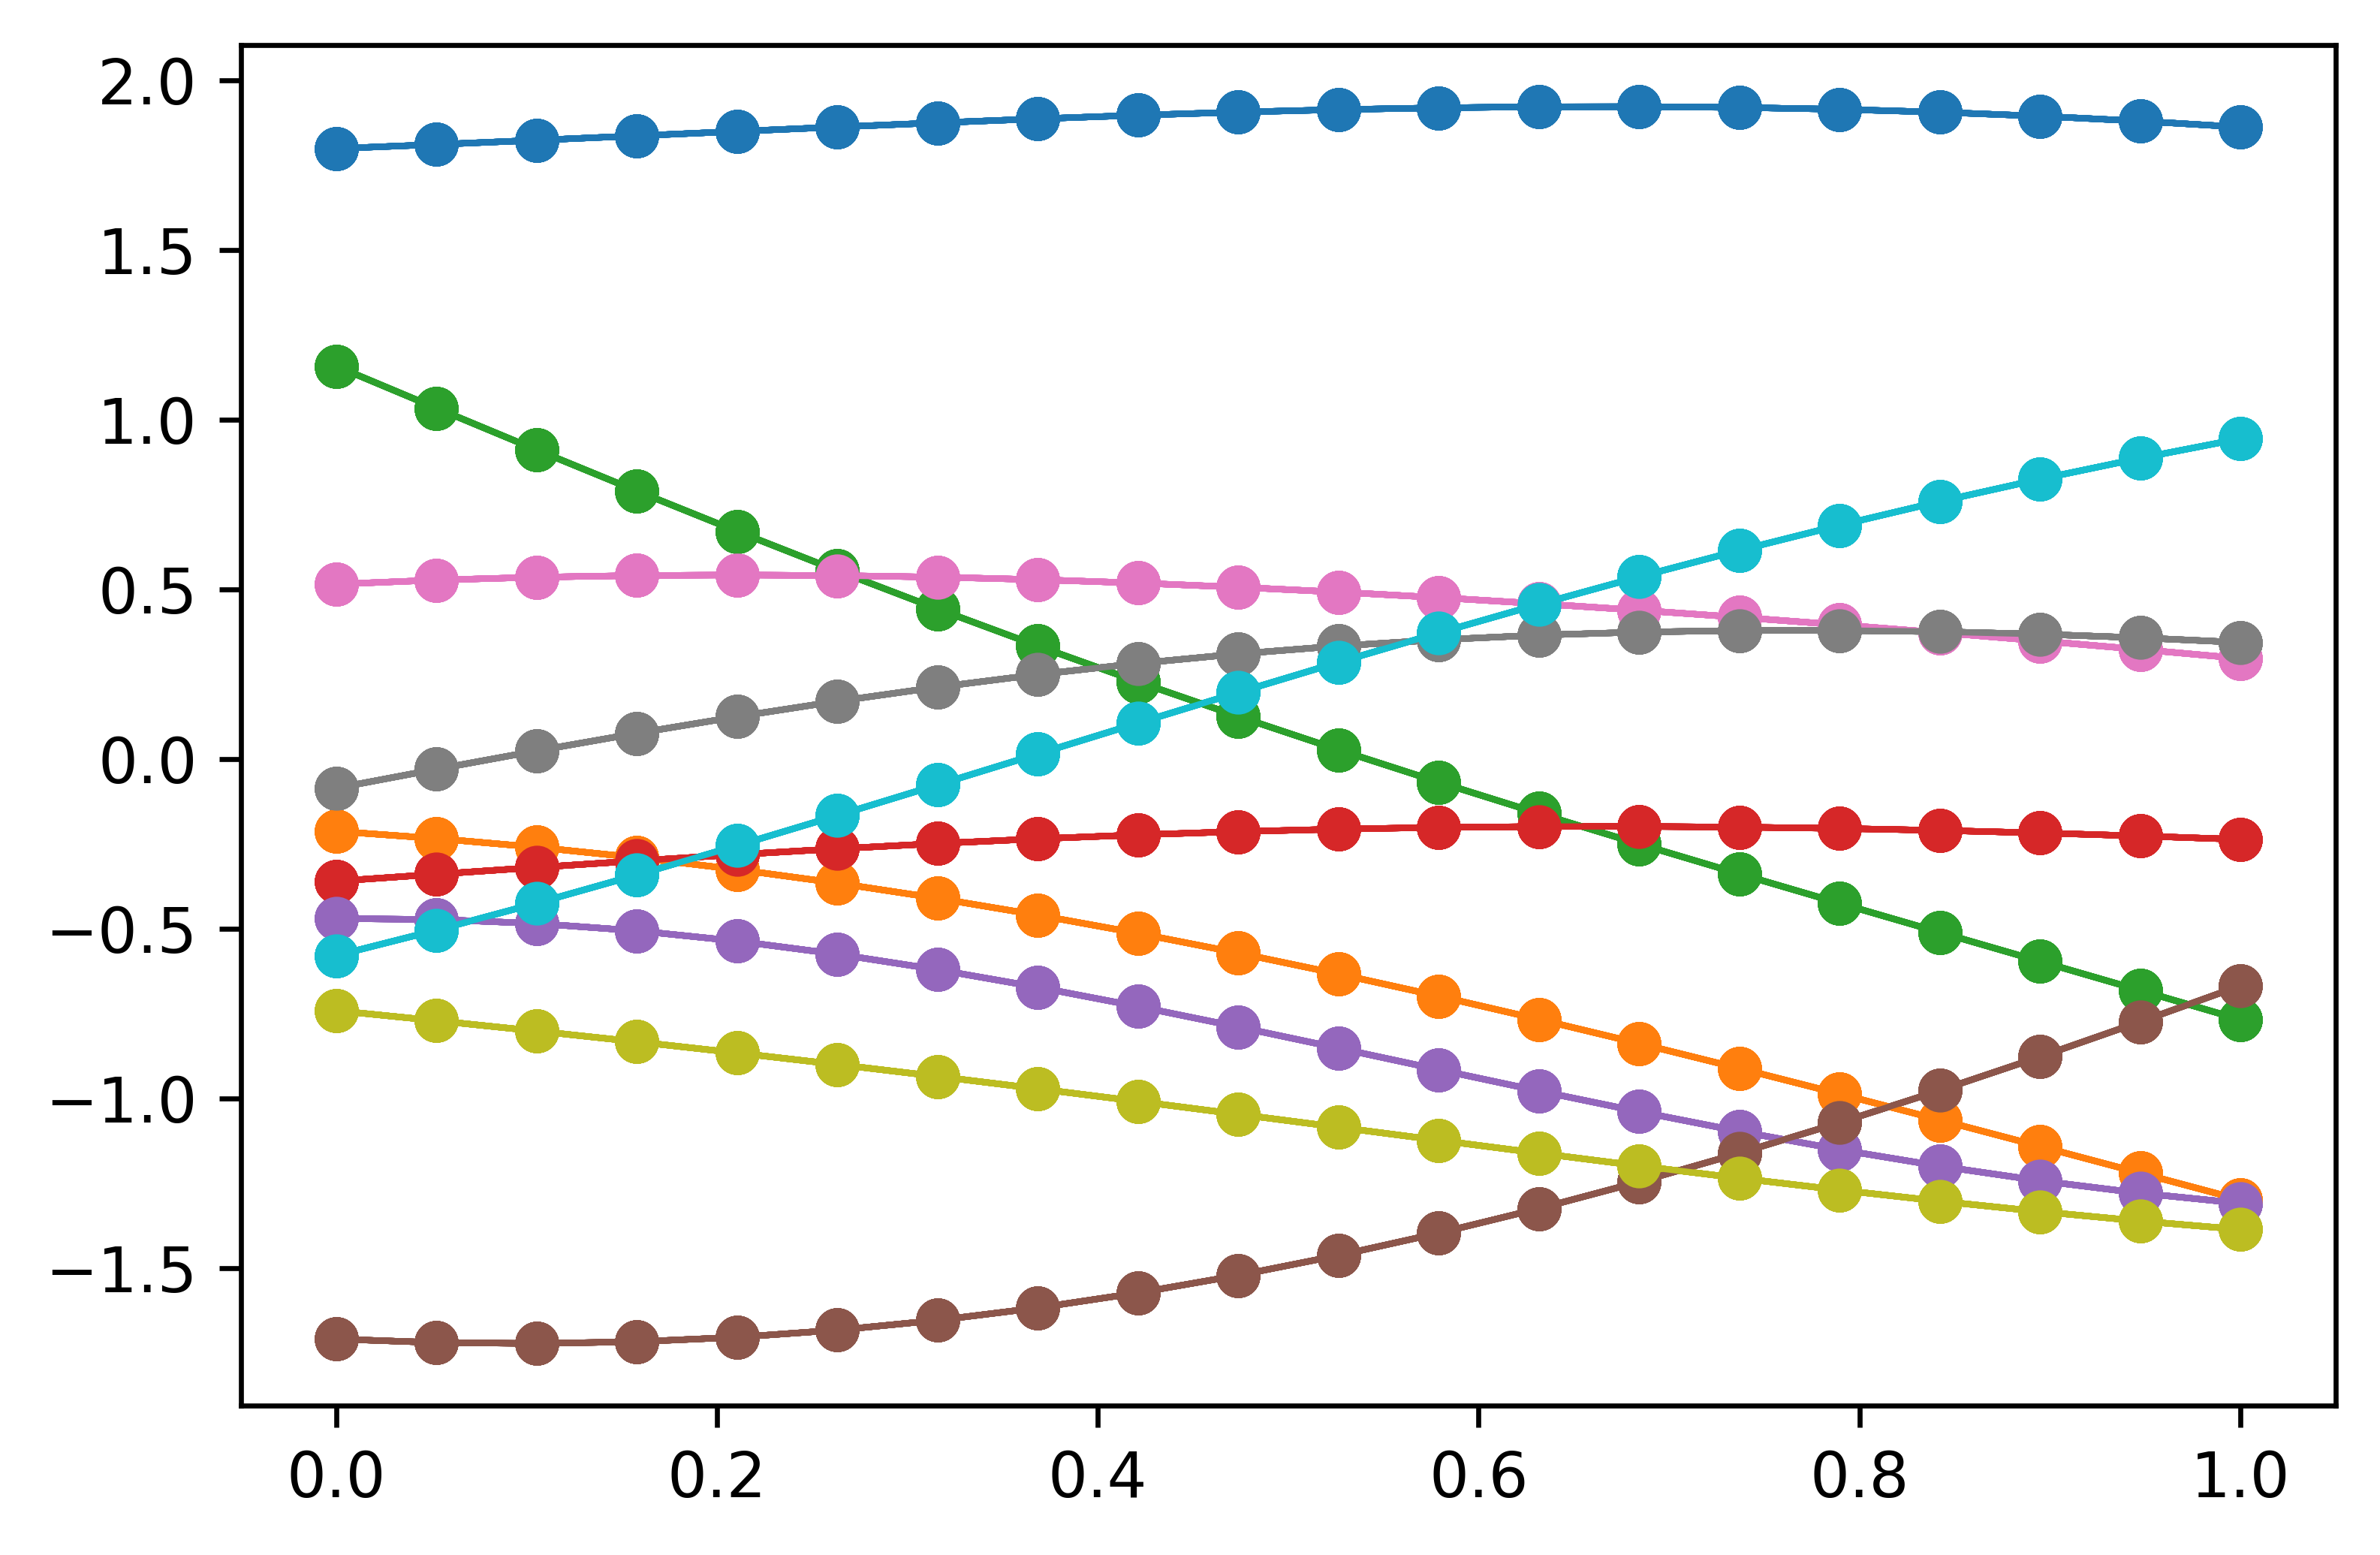

In [ ]:
n = 20  
m = 10

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

K_ = kernel(Xshow, Xshow)                  # k(x_star, x_star)        

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, K_, m).T

plt.clf()

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
# plt.title('10 samples of the 20-D gaussian kernelized prior')
# plt.show()
plt.savefig('20d_gaussian_kernel_prior')

We get much smoother lines and looks even more like functions. When the dimension of Gaussian gets larger, there is no need to connect points. When the dimension become infinity, there is a point represents any possible input. Let's plot `m=200` samples of `n=200`$-D$ Gaussian to get a feeling of functions with infinity parameters.  

<Figure size 432x288 with 0 Axes>

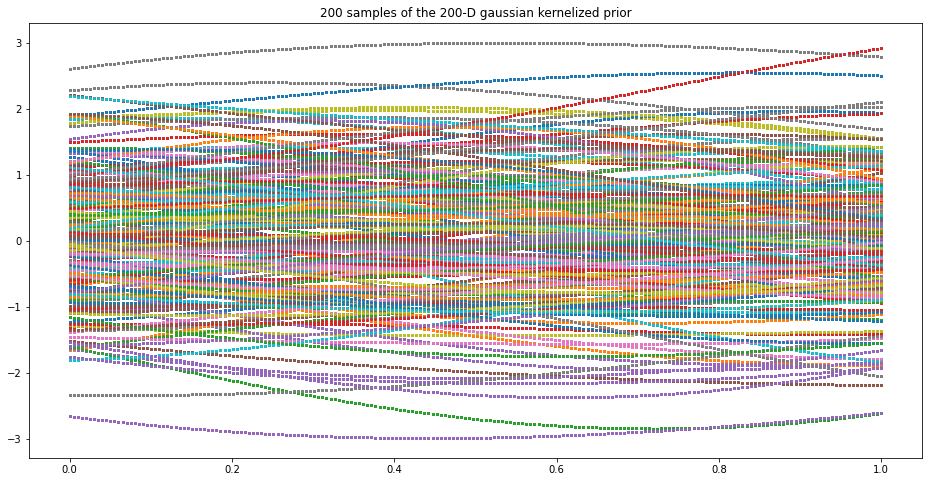

In [ ]:
n = 200         
m = 200

Xshow = np.linspace(0, 1, n).reshape(-1,1)   

K_ = kernel(Xshow, Xshow)                    # k(x_star, x_star)        

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, K_, m).T

plt.clf()
#plt.plot(Xshow, f_prior, '-o')
Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.figure(figsize=(16,8))
for i in range(m):
    plt.plot(Xshow, f_prior, 'o', linewidth=1, markersize=2, markeredgewidth=1)
    
plt.title('200 samples of the 200-D gaussian kernelized prior')
#plt.axis([0, 1, -3, 3])
plt.show()
#plt.savefig('priorT.png', bbox_inches='tight', dpi=300)

As we can see above, when we increase the dimension of Gaussian to infinity, we can sample all the possible points in our region of interest. 

A great visualization animation of two and four points covariance of the "functions" respectively [10].

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2points_covariance.gif?raw=1" width="600"/>
      	  
<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/4points_covariance.gif?raw=1" width="600"/>

---

Here we talk a little bit about **Parametric and Nonparametric model**. You can skip this section without compromising your Gaussian Process understandings. 

Parametric models assume that the data distribution can be modeled in terms of a set of finite number parameters. For regression, we have some data points, and we would like to make predictions of the value of $y=f(x)$ with a specific $x$. If we assume a linear regression model, $y = \theta_1  + \theta_2 x$, we need to find the parameters $\theta_1$ and $\theta_2$ to define the line. In many cases, the linear model assumption isn’t hold, a polynomial model with more parameters, such as $y = \theta_1+\theta_2 x+\theta_3 x^2$ is needed. We use the training dataset $D$ of $n$ observations, $D=[(x_i,y_i)\, \vert \, i=1,…,n]$ to train the model, i.e. mapping $x$ to $y$ through parameters $ \mathbf {\theta}= (\theta_1,\theta_2,\theta_3)$. After the training process, we assume all the information of the data are captured by the feature parameters $\mathbf{\theta}$, thus the prediction is independent of the training data $D$. It can be expressed as  $P(f_* \, \vert \,  X_*, \mathbf {\theta} ,D)=P(f_* \, \, \vert \,  X_*, \mathbf {\theta})$, in which $f_*$ is the prediction made at a unobserved point $x_*$. 
Thus, conducting regression using the parametric model, the complexity or flexibility of model is limited by the parameter numbers. It’s natural to think to use a model that the number of parameters grows with the size of the dataset, and it’s a Bayesian non-parametric model. Bayesian non-parametric model do not imply that there are no parameters, but rather infinitely parameters. 

---

To generate correlated normally distributed random samples, one can first generate uncorrelated samples, and then multiply them
by a matrix *L* such that $L L^T = K$, where *K* is the desired covariance matrix. *L* can be created, for example, by using 
the Cholesky decomposition of *K*.

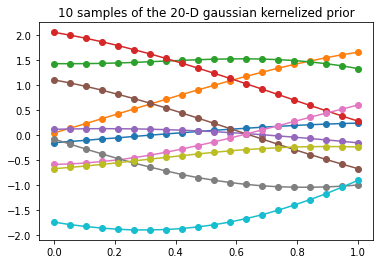

In [ ]:
n = 20      
m = 10

Xshow = np.linspace(0, 1, n).reshape(-1,1)  # n number test points in the range of (0, 1)

K_ = kernel(Xshow, Xshow)                

L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))


f_prior = np.dot(L, np.random.normal(size=(n,m)))

plt.clf()
plt.plot(Xshow, f_prior, '-o')
plt.title('10 samples of the 20-D gaussian kernelized prior')
plt.show()

## III. Math

First, again, going back to our task regression. There is a function $\mathbf{f}$ we are trying to model given a set of data points $\mathbf{X}$ (trainig data/existing observed data) from the unknow function $\mathbf{f}$. The traditional non-linear regression machine learning methods typically give one function that it considers to fit these observations the best. But, as shown at the begining, there can be more than one funcitons fit the observations equally well. 

Second, let's review what we got from MVN. We got the feeling that when the dimension of Gaussian is infinite, we can sample all the region of interest with random functions. These infinite random functions are MVN because it's our assumption (prior). More formally, the prior distribution of these infinite random functions are MVN. The prior distribution representing the kind out outputs $\mathbf{f}$ that we expect to see over some inputs $\mathbf{x}$ without even observing any data. 

When we have observation points, instead of infinite random functions, we only keep functions that are fit these points. Now we got our posterior, the current belief based on the existing observations. When we have more observation points, we use our previous posterior as our prior, use these new observations to update our posterior.  

This is **Gaussian process**. 

***A Gaussian process is a probability distribution over possible functions that fit a set of points.***

Because we have the probability distribution over all possible functions, we can caculate **the means as the function**, and caculate the variance to show how confidient when we make predictions using the function. 

Keep in mind, 
* The functions(posterior) updates with new observations. 
* The mean calcualted by the posterior distribution of the possible functions is the function used for regression. 

**Highly recommend to read Appendix A.1 and A.2 [3] before continue.** Basic math. 

The function is modeled by a multivarable Gaussian as 

$$p(\mathbf{f} \, \lvert\, \mathbf{X}) = \mathcal{N}(\mathbf{f} \, \lvert\, \boldsymbol\mu, \mathbf{K})$$

where $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_n))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_n))$ and $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$. $m$ is the mean function and it is common to use $m(\mathbf{x}) = 0$ as GPs are flexible enough to model the mean arbitrarily well. $\kappa$ is a positive definite *kernel function* or *covariance function*. Thus, a Gaussian process is a distribution over functions whose shape (smoothness, ...) is defined by $\mathbf{K}$. If points $\mathbf{x}_i$ and $\mathbf{x}_j$ are considered to be similar by the kernel the function values at these points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, can be expected to be similar too. 

So, we have observations, and we have estimated functions $\mathbf{f}$ with these observations. Now say we have some new points $\mathbf{X}_*$ where we want to predict $f(\mathbf{X}_*)$.

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/mvn.png?raw=1" width="250"/> 

The joint distribution of $\mathbf{f}$ and $\mathbf{f}_*$ can be modeled as:

$$ \begin{pmatrix}\mathbf{f} \\ \mathbf{f}_*\end{pmatrix} \sim\mathcal{N}\left(\begin{pmatrix}m(\mathbf{X})\\ m(\mathbf{X}_*)\end{pmatrix}, \begin{pmatrix}\mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}\right) $$

where $\mathbf{K}=\kappa(\mathbf{X}, \mathbf{X})$, $\mathbf{K}_* = \kappa(\mathbf{X}, \mathbf{X}_*)$ and $\mathbf{K}_{**}=\kappa(\mathbf{X}_*, \mathbf{X}_*)$. And $\begin{pmatrix}m(\mathbf{X})\\ m(\mathbf{X}_*)\end{pmatrix} = \mathbf{0}$

This is modeling a joint distribution $p(\mathbf{f}, \mathbf{f}_* \, \vert \, \mathbf{X}, \mathbf{X}_*)$, but we want the conditional distribution over $\mathbf{f}_*$ only, which is $p(\mathbf{f}_* \, \vert \, \mathbf{f}, \mathbf{X}, \mathbf{X}_*)$. The derivation process from the joint distribution $p(\mathbf{f}, \mathbf{f}_* \, \vert \, \mathbf{X}, \mathbf{X}_*)$ to the conditional $p(\mathbf{f}_* \, \vert \, \mathbf{f}, \mathbf{X}, \mathbf{X}_*)$ uses the **Marginal and conditional distributions of MVN** theorem [5].   

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/mvn_theorem.png?raw=1" width="420"/> 

We got eqn. 2.19 [1] 
$$\mathbf{f}_* \, \vert \, \mathbf{f}, \mathbf{X}, \mathbf{X}_* \sim \mathcal{N} (\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{f}, \: \mathbf{K}_{**}-\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*) $$

It is realistic modelling situations that we do not have access to function values themselves, but only noisy versions thereof $y = f(x) + \epsilon$. Assuming additive independent identically distributed Gaussian noise with
variance $\sigma_n^2$, the prior on the noisy observations becomes $cov(y) = \mathbf{K} + \sigma_n^2\mathbf{I}$. The joint distribution of the observed target values and the function values at the test locations under the prior as [1]

$$ \begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim\mathcal{N}\left(\mathbf{0}, \begin{pmatrix}\mathbf{K} + \sigma_n^2\mathbf{I} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}\right) $$
Deriving the conditional distribution corresponding to eqn. 2.19 we get the predictive equations (eqn. 2.22, eqn. 2.23, and eqn. 2.24) [1] for Gaussian process regression as

$$\mathbf{\bar{f}_*} \, \vert \, \mathbf{X}, \mathbf{y}, \mathbf{X}_* \sim \mathcal{N} \left(\mathbf{\bar{f}_*}, cov(\mathbf{f}_*)\right) $$

where, 
$$\mathbf{\bar{f}_*} \overset{\Delta}{=} \mathbb{E} [\mathbf{\bar{f}_*} \, \vert \, \mathbf{X}, \mathbf{y}, \mathbf{X}_*] = \mathbf{K}_*^T [\mathbf{K} + \sigma_y^2\mathbf{I}]^{-1} \mathbf{y} $$

$$cov(\mathbf{f}_*) = \mathbf{K}_{**} - \mathbf{K}_*^T [\mathbf{K} + \sigma_y^2\mathbf{I}]^{-1} \mathbf{K}_* $$

## IV. Simple Implementation Example

We do the regression example between -5 and 5. The observation data points (traing dataset) are generated from a uniform distribution between -5 and 5. This means any point value within the given interval [-5, 5] is equally likely to be drawn by uniform. The functions will be evaluated at `n` evenly spaced points between -5 and 5. We do this to show a continuous function for regression in our region of interest [-5, 5]. This is a simple example to do GP regression. It assumes a zero mean GP Prior. The code borrows heavily from Dr. Nando de Freitas’ Gaussian processes for nonlinear regression [lecture](https://youtu.be/4vGiHC35j9s) [6].

The algorithm executed follows 

The textbook [GPML](http://gaussianprocess.org/gpml/chapters/RW.pdf), P19. [1]

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/gp1.png?raw=1" width="600"/> 

Dr. Nando de Freitas, [Introduction to Gaussian processes](https://youtu.be/4vGiHC35j9s). [6]

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/gp.png?raw=1" width="500"/>

In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

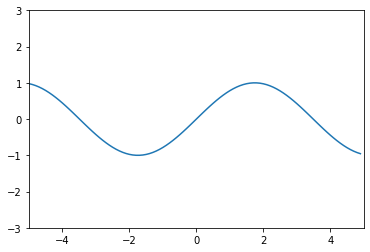

In [ ]:
# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()
x = np.arange(-5, 5, 0.1)

plt.plot(x, f(x))
plt.axis([-5, 5, -3, 3])
plt.show()

In [ ]:
# Define the kernel
def kernel(a, b):
    kernelParameter_l = 0.1
    kernelParameter_sigma = 1.0
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return kernelParameter_sigma*np.exp(-.5 * (1/kernelParameter_l) * sqdist)

We use a general Squared Exponential Kernel, also called Radial Basis Function Kernel or Gaussian Kernel:

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))
$$

where $\sigma_f$ and $l$ are hyperparameters. More information about the hyperparameters can be found after the codes. 

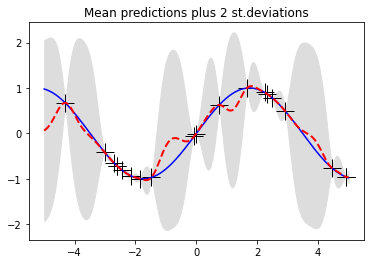

In [ ]:
# Sample some input points and noisy versions of the function evaluated at
# these points. 
N = 20         # number of existing observation points (training points).
n = 200        # number of test points.
s = 0.00005    # noise variance.

X = np.random.uniform(-5, 5, size=(N,1))     # N training points 
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))     # line 1 

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))   # k_star = kernel(X, Xtest), calculating v := l\k_star
mu = np.dot(Lk.T, np.linalg.solve(L, y))    # \alpha = np.linalg.solve(L, y) 

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)                  # k(x_star, x_star)        
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)   
s = np.sqrt(s2)

# PLOTS:
plt.figure(1)
plt.clf()
plt.plot(X, y, 'k+', ms=18)
plt.plot(Xtest, f(Xtest), 'b-')
plt.gca().fill_between(Xtest.flat, mu-2*s, mu+2*s, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
#plt.savefig('predictive.png', bbox_inches='tight', dpi=300)
plt.title('Mean predictions plus 2 st.deviations')
plt.show()
#plt.axis([-5, 5, -3, 3])

<Figure size 432x288 with 0 Axes>

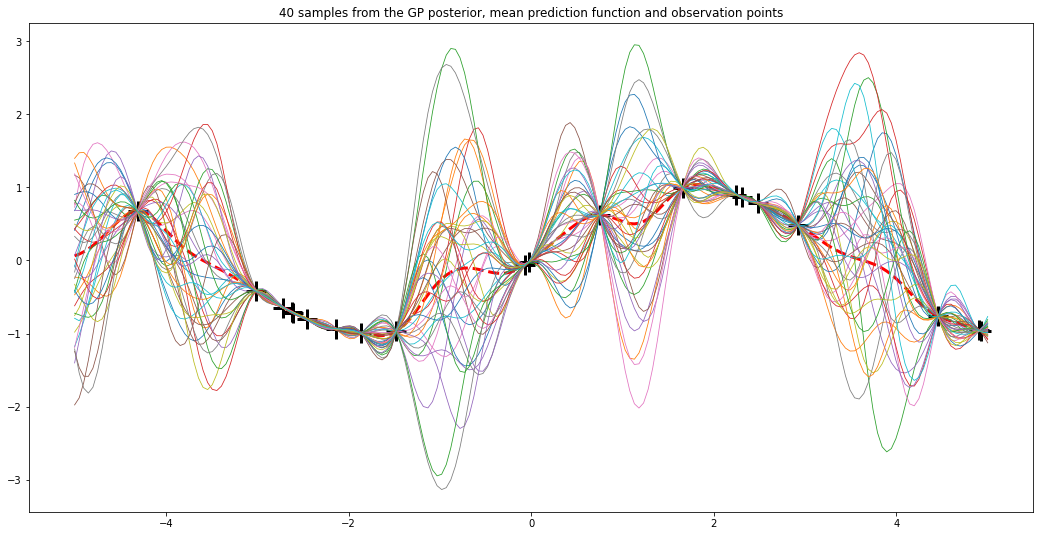

In [ ]:
# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,40)))  # size=(n, m), m shown how many posterior  
plt.figure(3)
plt.clf()
plt.figure(figsize=(18,9))
plt.plot(X, y, 'k+', markersize=20, markeredgewidth=3)
plt.plot(Xtest, mu, 'r--', linewidth=3)
plt.plot(Xtest, f_post, linewidth=0.8)
plt.title('40 samples from the GP posterior, mean prediction function and observation points')
plt.show()
#plt.axis([-5, 5, -3, 3])
#plt.savefig('post.png', bbox_inches='tight', dpi=600)

We plotted `m=40` samples from the Gaussian Process posterior together with the mean function for prediction and the observation data points (training dataset). It's clear all posterior functions collapse at all observation points. 

## V. Build a Real Gaussian Process 

So far, we talked about the basics and demonstrate with a simple GP implementation. While, the real GP model is more complex than above. First of all, kernels play significant roles in GP. In kernels, hyperparameters are essential. Let's use the most common used kernel, RBF, as an example. 

The general RBF kernel:

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))\tag{6}
$$

where $\sigma_f$ and $l$ are hyperparameters. [7]

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/hyperparameter.png?raw=1" width="700"/>

  The proper hyperparameters (for RBF, $\mathbf{\theta} = [\sigma_f, l]$) are determined by the `Maximum Likelihood Estimate` as:  

$$ \mathbf{\theta^*} = \arg\max\limits_{\theta} \log p(y \, \vert \, \mathbf{X}, \mathbf{\theta}) $$ 

Thus, the more general equation of predicting on test points given the observed data and the optimized hyper-parameters is [11]:  

$$\mathbf{\bar{f}_*} \, \vert \, \mathbf{X}, \mathbf{y}, \mathbf{X}_*,  \mathbf{\theta} \sim \mathcal{N} \left(\mathbf{\bar{f}_*}, cov(\mathbf{f}_*)\right) $$

More intuition about hyperparameters estimate can be gained by runing my ***modified*** GPR tutorials of [GPyTorch](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb) and [GPflow](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression_GPflow.ipynb). 

The kernel functions are selected depending on the specific tasks. More information about choosing the kernel/covariance function for a Gaussian process can be found in `The Kernel Cookbook` [8]. 

### GP Packages

There are several packages or frameworks available to conduct Gaussian Process Regression. In this section, I will summarize my initial impression after trying several of them written in Python. 

A lightweight one is [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/gaussian_process.html), simple implementation like the example above can be quickly conducted. Just for gaining more implementation understandings of GP after the above simple implementation example. It's too vague for understanding GP theory purpose. 

GPR is computationally expensive in high dimensional spaces (features more than a few dozens) due to the fact it uses the whole samples/features to do the predictions. The more observations, the more computations are needed for predictions. A package that includes state-of-the-art algorithm implementations is preferred for efficient implementation of complex GPR tasks.

One of the most well-known GP frameworks is [GPy](https://sheffieldml.github.io/GPy/). GPy has been developed pretty maturely with well-documented explanations. GPy uses NumPy to perform all its computations. For tasks that don't require heavy computations and very up-to-date algorithm implementations, GPy is sufficient and the more stable. 

For bigger computation required GPR tasks, GPU acceleration are especially preferred. [GPflow](https://www.gpflow.org/) origins from GPy, and much of the interface is similar. GPflow leverages **TensorFlow** as its computational backend. More technical difference between GPy and GPflow frameworks is [here](https://gpflow.readthedocs.io/en/master/intro.html#what-s-the-difference-between-gpy-and-gpflow). 

[GPyTorch](https://gpytorch.ai/) is another framework that provides GPU acceleration through **PyTorch**. It contains very up-to-date GP algorithms. Similar to GPflow, GPyTorch provides automatic gradients. So complex models such as embedding deep NNs in GP models can be easier developed. 

After going through docs quickly and implementing basic GPR tutorials of [GPyTorch](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb) and [GPflow](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression_GPflow.ipynb), my impression is using GPyTorch is more automatic and GPflow has more controls. The impression may also come from the usage experience with TensorFlow and PyTorch. 

Check and run my ***modified*** GPR tutorials of [GPyTorch](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb) and [GPflow](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression_GPflow.ipynb). 


## VI. Summary

A Gaussian process (GP) is a probability distribution over possible functions that fit a set of points. [1] GPs are nonparametric models that model the function directly. Thus, GP provides a distribution (with uncertainty) for the prediction value rather than just one value as the prediction. In robot learning, quantifying uncertainty can be extremely valuable to achieve an efficient learning process. The areas with least certain should be explored next. This is the main idea behind Bayesian optimization. [9] Moreover, prior knowledge and specifications about the shape of the model can be added by selecting different kernel functions. [1] Priors can be specified based on criteria including if the model is smooth, if it is sparse, if it is able to change drastically, and if it need to be differentiable.



### Extra words

1. For simplicity and understanding reason, I ignore many math and technical talks. Read the first two chapters of the textbook `Gaussian Process for Machine Learning` [1] serveral times to get a solid understanding of GPR. 

2. One of most tricky part in understanding GP is the mapping projection among **spaces**. From input space to latent (feature) space and back to output space. You can get some feeling about space by reading [`autoencoder`](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d).

3. All information above is about the ***Standard/Plain Gaussian Process*** [11]. It has two main constraints:  
  * The overall computation complexity is $O(N^3)$, $N$ is the dimension of covariance matrix $K$.
  * The memory consumption is quadratic

  Because of the computation complexity and memory consumption, the   standard GP gets struck quickly when there are more than 5000 for CPU and 13000 data points for GPU. For big datasets, **sparse GP** is needed. 

## Reference

[1]	C. E. Rasmussen and C. K. I. Williams, Gaussian processes for machine learning. MIT Press, 2006.

[2] R. Turner, “ML Tutorial: Gaussian Processes - YouTube,” 2017. [Online]. Available: https://www.youtube.com/watch?v=92-98SYOdlY&feature=emb_title.

[3] A. Ng, “Multivariate Gaussian Distribution - Stanford University | Coursera,” 2015. [Online]. Available: https://www.coursera.org/learn/machine-learning/lecture/Cf8DF/multivariate-gaussian-distribution.

[4]	D. Lee, “Multivariate Gaussian Distribution - University of Pennsylvania | Coursera,” 2017. [Online]. Available: https://www.coursera.org/learn/robotics-learning/lecture/26CFf/1-3-1-multivariate-gaussian-distribution.

[5]	F. Dai, Machine Learning Cheat Sheet: Classical equations and diagrams in machine learning. 2017.

[6]	N. de Freitas, “Machine learning - Introduction to Gaussian processes - YouTube,” 2013. [Online]. Available: https://www.youtube.com/watch?v=4vGiHC35j9s&t=1424s.

[7]	Y. Shi, “Gaussian Process, not quite for dummies,” 2019. [Online]. Available: https://yugeten.github.io/posts/2019/09/GP/.

[8]	D. Duvenaud, “Kernel Cookbook,” 2014. [Online]. Available: https://www.cs.toronto.edu/~duvenaud/cookbook/.

[9]	Y. Gal, “What my deep model doesn’t know.,” 2015. [Online]. Available: http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html.

[10] J. Hensman, "Gaussians." 2019. [Online]. Available: https://github.com/mlss-2019/slides/blob/master/gaussian_processes/presentation_links.md.  

[11] Z. Dai, "GPSS2019 - Computationally efficient GPs" 2019. [Online]. Available: https://www.youtube.com/watch?list=PLZ_xn3EIbxZHoq8A3-2F4_rLyy61vkEpU&v=7mCfkIuNHYw. 

## Appendix A

Visualizing 3D plots of a $2-D$ Gaussian by [Visualizing the bivariate Gaussian distribution](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/). 

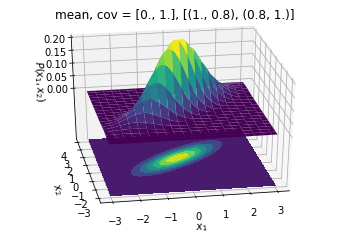

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , 0.8], [0.8,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.2, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.2,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(30, -100)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$P(x_1, x_2)$')

plt.title('mean, cov = [0., 1.], [(1., 0.8), (0.8, 1.)]')
plt.savefig('2d_gaussian3D_0.8.png', dpi=600)
plt.show()